In [1]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.models import Model
from keras.models import Sequential
from keras.layers import *
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
remote = callbacks.RemoteMonitor(root='http://localhost:9000')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from keras.utils.visualize_util import plot
from keras.optimizers import *
%matplotlib inline
from PIL import Image
import os
import random
import numpy
from keras.models import Sequential
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import model_from_json
from keras.applications.resnet50 import preprocess_input, decode_predictions
from convnetskeras.customlayers import Softmax4D
import gc
from convnetskeras.convnets import preprocess_image_batch, convnet
from convnetskeras.imagenet_tool import synset_to_dfs_ids
import PIL
from PIL import Image,ImageFilter, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
from matplotlib.patches import Ellipse
from numpy.linalg import eig, inv
import scipy
from scipy import ndimage
from skimage import data, io, filters
from skimage import data, img_as_float
from skimage import exposure
import math
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
import skimage
import collections
import json
import pickle
import numpy as np
from keras.layers.core import  Lambda, Merge
from keras.layers.convolutional import Convolution2D
from keras import backend as K
from keras.engine import Layer
from os import listdir
from os.path import isfile, join, dirname
from scipy.io import loadmat
import gc
from keras.utils.layer_utils import layer_from_config
from keras.models import Model
from keras.layers import *

Using Theano backend.
Using gpu device 0: GeForce GTX 960M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)


In [205]:

nf = 128
p=0.1
## GET ALL IMAGES FROM TRAIN SET RESIZE 
def get_json(json_path='./'):
    jsons = [f for f in os.listdir(json_path) if '.json' in f and 'labels' in f]
    data_json = collections.defaultdict(int)
    for fjson in jsons:
        with open(fjson,'r+') as f:
            name = fjson.split('_')[0].upper()
            data_json[name] = collections.defaultdict(list)
            labels = json.load(f)
            for label in labels:
                img_name = label['filename'].split('/')[-1]
                data_json[name][img_name] = label['annotations'] 
    return data_json

def rescale(img):
    img = img - img.min()
    return 255*(img/img.max())

def get_wanted_data(json_data,input_path,size,class_name,img_name,classes,size_b=True,rect_b=True,pil=False):
    from keras.preprocessing import image
    out_data = {}
    Size = size
    try:
        annotations = json_data[class_name][img_name]
        if len(annotations) ==1:
            annotations = [annotations]
        img_path = input_path+class_name+"/"+img_name
        img = image.load_img(img_path)
        if pil:
            out_data['pil'] = img.resize(size, PIL.Image.ANTIALIAS)
        SIZE = img.size
        x_r = Size[0]/SIZE[0]
        y_r = Size[1]/SIZE[1]
        #out_data['img']=image.img_to_array(img)
        if size != (None,None):
            img = scipy.misc.imresize(img, size, interp='bilinear', mode=None)
        out_data['img_r']=rescale(image.img_to_array(img))
        if size_b: 
            out_data['size'] = SIZE
        if rect_b: 
            out_data['rect'] = []
            for a in annotations:
                out_data['rect'].append([a['x']*x_r,a['y']*y_r,a['width']*x_r,a['height']*y_r])
        out_data['t'] = []
        for classe in classes:
            if classe == class_name:
                out_data['t'].append(1)
            else:
                out_data['t'].append(0)        
    except:
        img_path = input_path+class_name+"/"+img_name
        img = image.load_img(img_path)
        if pil:
            out_data['pil'] = img.resize(size, PIL.Image.ANTIALIAS)
        SIZE = img.size
        #out_data['img']=image.img_to_array(img)
        if size != (None,None):
            img = scipy.misc.imresize(img, size, interp='bilinear', mode=None)
        out_data['img_r']=rescale(image.img_to_array(img))
        if size_b: 
            out_data['size'] = SIZE
        if rect_b: 
            out_data['rect'] = [0,0,0,0]
        out_data['t'] = []
        for classe in classes:
            if classe == class_name:
                out_data['t'].append(1)
            else:
                out_data['t'].append(0)   
    return out_data
    

def load_train_save(input_path,pickle_path,json_path='./',size=(400,400),size_b=True,rect_b=True):
    import glob,PIL,collections,pickle,scipy
    from keras.preprocessing import image
    from tqdm import tqdm_notebook as tq
    data = collections.defaultdict(int)
    classes = [direc for direc in os.listdir(input_path) if direc!='.DS_Store' and direc!='.DS_Store']
    print(classes)
    imgs = collections.defaultdict(list)
    imgs_name = [[classe,os.listdir(input_path+classe)] for classe in classes]
    jsons_data = get_json(json_path)
    for classe in imgs_name:
        class_name = classe[0]
        imgs_name_class = classe[1]
        data[class_name]=collections.defaultdict(list)
        for img_name in tq(imgs_name_class):
            data[class_name][img_name]=get_wanted_data(jsons_data,input_path,size,class_name,img_name,classes,size_b,rect_b)
    with open(pickle_path,'wb') as f:
        pickle.dump(data, f, -1)

def get_wanted_crop_data(image_path,size,classes,class_name,img_name):
    from keras.preprocessing import image
    out_data = {}
    out_data['class'] = class_name
    out_data['img_name'] = img_name    
    img = image.load_img(image_path)
    if size != (None,None):
        img = scipy.misc.imresize(img, size, interp='bilinear', mode=None)
    out_data['img_r']=rescale(image.img_to_array(img))
    out_data['t'] = []
    for classe in classes:
        if classe == class_name:
            out_data['t'].append(1)
        else:
            out_data['t'].append(0) 
    return out_data
    

def binary_generator(binary_path_train,binary_path_test,size,batch_size=16):
    import glob,PIL,collections,pickle,scipy
    from keras.preprocessing.image import ImageDataGenerator
    from tqdm import tqdm_notebook as tq
    data_gen_args = dict(
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.,
        zoom_range=0.1,
        )

    train_datagen = ImageDataGenerator(**data_gen_args)
    validation_datagen = ImageDataGenerator(**data_gen_args)
    test_datagen = ImageDataGenerator(**data_gen_args)

    train_generator = train_datagen.flow_from_directory(binary_path_train, batch_size=batch_size,target_size=size)
    validation_generator = validation_datagen.flow_from_directory(binary_path_train, batch_size=batch_size,target_size=size)
    test_generator = validation_datagen.flow_from_directory(binary_path_test, batch_size=batch_size,target_size=size)
    return train_generator,validation_generator,test_generator

def load_pickle(pickle_path):
    with open('data_all.g','rb') as f:
        unpickler = pickle.Unpickler(f);
        return unpickler.load();    
def split_at(model, layer_type):
    layers = model.layers
    layer_idx = [index for index,layer in enumerate(layers)
                 if type(layer) is layer_type][-1]
    return layers[:layer_idx+1], layers[layer_idx+1:]

def get_fold(data,alpha):
    import random
    X,Y,x,y,Y_r,y_r,X_img,x_img = [],[],[],[],[],[],[],[]
    used = []
    imgs_metadata = [[[cl,img_name] for img_name in data[cl].keys()] for cl in data.keys()]
    counts = [0 for cl in data.keys()]
    classes_L = [len(data[cl].keys()) for cl in data.keys()]
    L = np.array(classes_L).sum()
    for i in range(len(counts)):
        for img_meta in imgs_metadata[i]:
            if counts[i] < int(classes_L[i]*alpha):
                cl = img_meta[0]
                img_name = img_meta[1]
                X.append(data[cl][img_name]['img_r'])
                Y.append(data[cl][img_name]['t'])
                Y_r.append(data[cl][img_name]['rect'])
                X_img.append([cl,img_name,data[cl][img_name]['img_r']])
                counts[i]+=1
                         
            else:
                cl = img_meta[0]
                img_name = img_meta[1]
                x.append(data[cl][img_name]['img_r'])
                y.append(data[cl][img_name]['t'])
                y_r.append(data[cl][img_name]['rect'])
                x_img.append([cl,img_name,data[cl][img_name]['img_r']])
                counts[i]+=1                         
    X = np.array(X)
    Y = np.array(Y)
    x = np.array(x)
    y = np.array(y)
    Y_r = np.array(Y_r)
    y_r = np.array(y_r)   
    return X,Y,x,y,Y_r,y_r,x_img,X_img
def conv_RESNET50():
    base_model = ResNet50(weights='imagenet', include_top=False,input_shape=(3,197,197))
    conv_layers,fc_layers = split_at(base_model, Convolution2D)
    return Model(input=base_model.input,output=conv_layers[-1].output),conv_layers
def get_lrg_layers(p,conv_layers):
    return [
        BatchNormalization(input_shape=conv_layers[-1].output_shape[1:]),
        Convolution2D(nf*2,3,3, activation='relu', border_mode='same'),
        BatchNormalization(),
        Dropout(p),
        Convolution2D(nf*2,3,3, activation='relu', border_mode='same'),
        BatchNormalization(),
        Dropout(p),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(),
        Dropout(p),
        Convolution2D(nf,3,3, activation='relu', border_mode='same'),
        BatchNormalization(),
        Dropout(p),
        Convolution2D(8,3,3, border_mode='same'),
        GlobalAveragePooling2D(),
        Activation('softmax')
    ]
def conv2d_bn(x, nb_filter, nb_row, nb_col, subsample=(1, 1)):
    x = Convolution2D(nb_filter, nb_row, nb_col,
                      subsample=subsample, activation='relu', border_mode='same')(x)
    return BatchNormalization()(x)
def incep_block(x):
    branch1x1 = conv2d_bn(x, 32, 1, 1, subsample=(2, 2))
    branch5x5 = conv2d_bn(x, 24, 1, 1)
    branch5x5 = conv2d_bn(branch5x5, 32, 5, 5, subsample=(2, 2))

    branch3x3dbl = conv2d_bn(x, 32, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 48, 3, 3, subsample=(2, 2))

    branch_pool = AveragePooling2D(
        (3, 3), strides=(2, 2), border_mode='same')(x)
    branch_pool = conv2d_bn(branch_pool, 16, 1, 1)
    return merge([branch1x1, branch5x5, branch3x3dbl, branch_pool],
              mode='concat', concat_axis=1)

def train_model(nf,p,n,input_model ='RESNET50',output_model='1'):
    if input_model == 'RESNET50' and output_model=='1':
        conv_resnet50,conv_layers = conv_RESNET50()
        x = conv_resnet50.output
        x = BatchNormalization(input_shape=conv_layers[-1].output_shape[1:])(x)
        x = Convolution2D(nf*2,3,3, activation='relu', border_mode='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(p)(x)
        x = Convolution2D(nf*2,3,3, activation='relu', border_mode='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(p)(x)
        x = Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(p)(x)
        x = Convolution2D(nf,3,3, activation='relu', border_mode='same')(x)
        x = BatchNormalization()(x)
        x = Dropout(p)(x)
        x = Convolution2D(n,3,3, border_mode='same')(x)
        x = GlobalAveragePooling2D()(x)
        output = Activation('softmax')(x)

        for layer in conv_resnet50.layers:
            layer.trainable = False
            
        model = Model(input=conv_resnet50.input,output=output)
        model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy',metrics=['accuracy'])        
        nb_epoch = 10
        return model
    if input_model == 'RESNET50' and output_model=='2':
        conv_resnet50,conv_layers = conv_RESNET50()
        x = conv_resnet50.output
        x = BatchNormalization(input_shape=conv_layers[-1].output_shape[1:])(x)
        x = incep_block(x)
        x = incep_block(x)
        x = incep_block(x)
        x = Dropout(0.75)(x)
        x = Convolution2D(n,3,3, border_mode='same')(x)
        x = GlobalAveragePooling2D()(x)
        output = Activation('softmax')(x)
        
        for layer in conv_resnet50.layers:
            layer.trainable = False
            
        model = Model(input=conv_resnet50.input,output=output)
        model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy',metrics=['accuracy'])        
        nb_epoch = 10
        return model
def save_model(model,model_name):
    from keras.models import model_from_json
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_name+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(model_name+".h5")
    print("Saved model to disk")

In [206]:
model = train_model(256,0.1,8,output_model='2')
#model.summary()

In [207]:
#load_train_crop_save('cropped_train/_gen/','data_crop_all.g','./',(197,197),True,True)
# 8 c : 'cropped_train/_gen','cropped_test/_gen'
# 2 c : 'binary_dataset/train','binary_dataset/test'
train_generator,validation_generator,test_generator = binary_generator('cropped_train/_gen','cropped_test/_gen',(197,197),batch_size=16)
nb_epoch = 100
for batch_X,batch_Y in train_generator:
    print(batch_X.shape)
    break
model.fit_generator(train_generator,
                samples_per_epoch=1024,
                nb_epoch=nb_epoch,
                validation_data=validation_generator,
                verbose=1,
                nb_val_samples=256, callbacks=[remote])        

Found 15929 images belonging to 8 classes.
Found 15929 images belonging to 8 classes.
Found 4025 images belonging to 8 classes.
(16, 3, 197, 197)
Epoch 1/100
1024/1024 [==============================] - 45s - loss: 2.2377 - acc: 0.1758 - val_loss: 2.0698 - val_acc: 0.1055
Epoch 2/100
1024/1024 [==============================] - 36s - loss: 1.9184 - acc: 0.3115 - val_loss: 2.0593 - val_acc: 0.1133
Epoch 3/100
1024/1024 [==============================] - 34s - loss: 1.7284 - acc: 0.3438 - val_loss: 1.9328 - val_acc: 0.3086
Epoch 4/100
1024/1024 [==============================] - 33s - loss: 1.5041 - acc: 0.4512 - val_loss: 1.7725 - val_acc: 0.3086
Epoch 5/100
1024/1024 [==============================] - 31s - loss: 1.3165 - acc: 0.5273 - val_loss: 1.4904 - val_acc: 0.3711
Epoch 6/100
1024/1024 [==============================] - 30s - loss: 1.2524 - acc: 0.5684 - val_loss: 1.0754 - val_acc: 0.6094
Epoch 7/100
1024/1024 [==============================] - 29s - loss: 1.2001 - acc: 0.5781 - 

D:\Software\Anaconda3\lib\site-packages\keras\keras\engine\training.py:1470: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


1033/1024 [==============================] - 24s - loss: 1.0083 - acc: 0.6370 - val_loss: 0.7700 - val_acc: 0.7031
Epoch 17/100
1024/1024 [==============================] - 23s - loss: 0.9091 - acc: 0.6699 - val_loss: 0.6307 - val_acc: 0.7500
Epoch 18/100
1024/1024 [==============================] - 23s - loss: 0.8328 - acc: 0.7021 - val_loss: 0.7245 - val_acc: 0.7461
Epoch 19/100
1024/1024 [==============================] - 23s - loss: 0.9144 - acc: 0.6592 - val_loss: 0.6745 - val_acc: 0.7344
Epoch 20/100
1024/1024 [==============================] - 23s - loss: 0.9048 - acc: 0.6895 - val_loss: 0.7954 - val_acc: 0.7148
Epoch 21/100
1024/1024 [==============================] - 23s - loss: 0.9348 - acc: 0.6816 - val_loss: 0.6669 - val_acc: 0.7461
Epoch 22/100
1024/1024 [==============================] - 24s - loss: 0.8547 - acc: 0.6846 - val_loss: 0.8172 - val_acc: 0.7031
Epoch 23/100
1024/1024 [==============================] - 23s - loss: 0.8430 - acc: 0.7021 - val_loss: 0.6096 - val_a

In [157]:
data = load_pickle('data_all.g')

In [211]:
#load_train_crop_save('cropped_train/_gen/','data_crop_all.g','./',(197,197),True,True)
# 8 c : 'cropped_train/_gen','cropped_test/_gen'
# 2 c : 'binary_dataset/train','binary_dataset/test'
X,Y,x,y,Y_r,y_r,x_img,X_img = get_fold(data,0.8)


In [218]:
def rescale(img):
    img = img - img.min()
    return img/img.max()
def to_plot(img):
    return np.rollaxis(img, 0, 3).astype(np.uint8)
def plot(img):
    plt.imshow(img)
def get_cm(imp, label):
    conv = conv_fn([inp,0])[0, label]
    return scipy.misc.imresize(conv, (197,197), interp='nearest')
def rescale(img):
    img = img - img.min()
    return 255*(img/img.max())
def pixel_rescale(pixel):
    return 255 - pixel
def inverse_pixel(img):
    out = np.array((3,197,197))
    for i in range(3):
        for x in range(197):
            for y in range(197):
                out[i,x,y] = pixel_rescale(img[i,x,y])
    return np.array(out)
def binarize(value, threshold,state=True):
    if state:
        if value < threshold:
            return 255
        else:
            return 0
    else:
        if value < threshold:
            return 0
        else:
            return 255        
def filter_mask(img,heatmap,th,state):
    img2 = np.multiply(img,rescale_01(heatmap))
    np_binarize = np.vectorize(binarize)
    bb = np_binarize(heatmap,th,state)
    img_array = np.array(img)
    mask = np.zeros_like(img_array)
    for i in range(3):
        mask[i,:,:] = bb
    idx=(mask==0)
    img[idx]=mask[idx]
    return img,img2

def rescale_01(img):
    return img/img.max()

def plots(N,m,M):
    l = model.layers
    plt.figure()
    plt.imshow(data[x_img[N][0]][x_img[N][1]]['pil'])
    conv_fn = K.function([l[0].input, K.learning_phase()], l[-4].output)
    inp = np.expand_dims(x[N], 0)
    def get_cm(imp, label):
        conv = conv_fn([inp,0])[0, label]
        return scipy.misc.imresize(conv, (197,197), interp='nearest')
    #np.round(lrg_model.predict(inp)[0],2)
    #predict = model.predict(inp)[0]
    #j = 0
    #MAX = predict.max()
    #for i,value in enumerate(predict.tolist()):
    #    p = predict.tolist()
    #    if p[i] == MAX:
    #        j=i
    cm = np.array(rescale(get_cm(inp, m)))
    print(cm.shape)
    plt.figure()
    print(x_img[N][0]+' '+x_img[N][1])
    plt.imshow(rescale(cm), cmap="cool")
    plt.title(x_img[N][0]+' '+x_img[N][1])
    plt.figure(figsize=(10,10))
    plot(data[x_img[N][0]][x_img[N][1]]['pil'])
    plt.imshow(cm, cmap="cool", alpha=0.5)
    plt.title(x_img[N][0]+' '+x_img[N][1])
    img,img2 = filter_mask(rescale_01(x[N]),rescale_01(cm),0.6,False)
    print(img2.shape)
    plt.figure()
    IMG2 = np.rollaxis(img2, 0,3)
    plt.imshow(IMG2)
    plt.figure()
    IMG = np.rollaxis(img, 0,3)
    plt.imshow(IMG)
    plt.figure()
    img3 = np.rollaxis(img-img2, 0,3)
    plt.imshow(img3)
    cm3 = np.array(get_cm(img3, m))
    plt.figure()
    plt.imshow(cm3, cmap="cool")


(197, 197)
BET img_03918.jpg
(3, 197, 197)


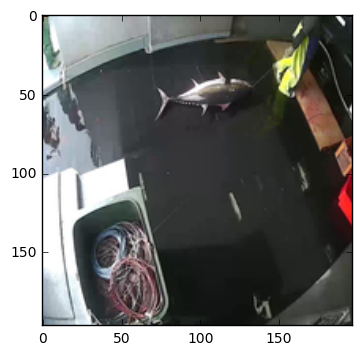

D:\Software\Anaconda3\lib\site-packages\numpy\ma\core.py:4185: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


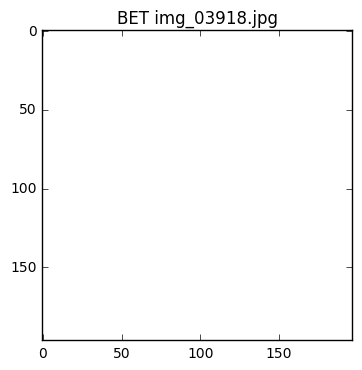

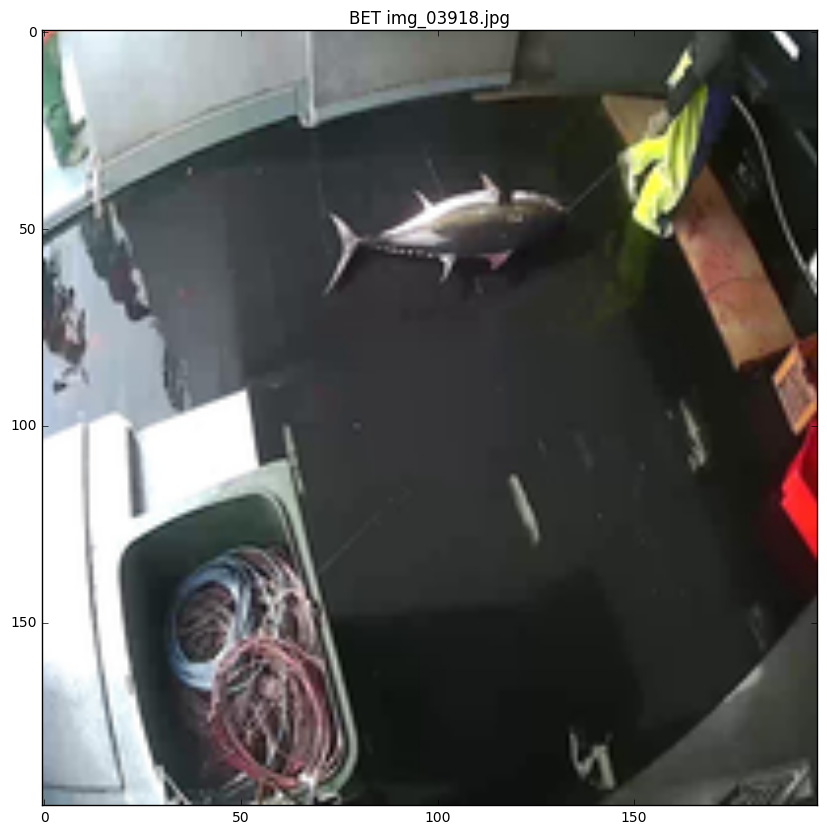

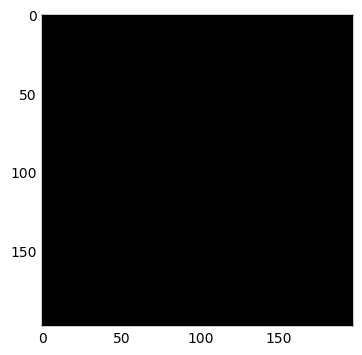

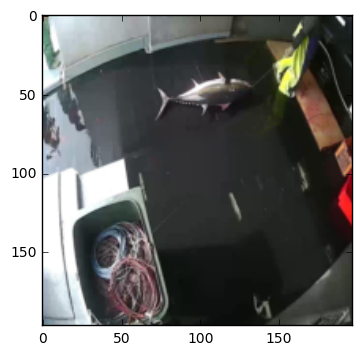

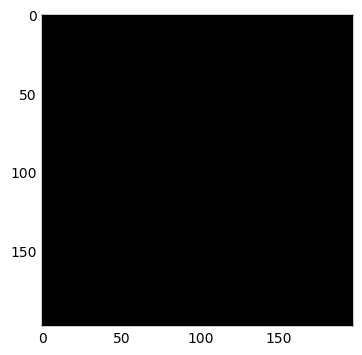

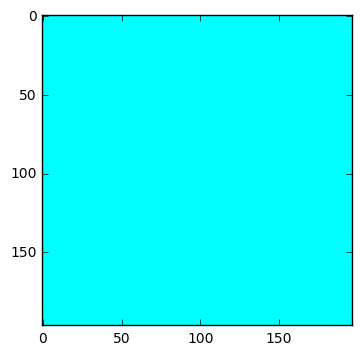

In [219]:
N = 2
plots(N,0,'')

In [47]:
def create_submission(predictions, info):
    import pandas as pd
    import datetime
    #result1 = pd.DataFrame(predictions, columns=['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT','image'])
    result1 = pd.DataFrame(predictions, columns=['image','ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT'])
    #result1.loc['image',:] = pd.Series(test_id, index=result1.index)
    now = datetime.datetime.now()
    sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
    result1.to_csv(sub_file, index=False)
    print('done',sub_file)
    
def get_predict(test_path,size=(197,197)):
    import os
    from keras.preprocessing import image
    imgs = []
    imgs_name = [f for f in os.listdir(test_path)]
    for img_name in imgs_name:
        img = scipy.misc.imresize(image.load_img(test_path+img_name), size, interp='bicubic')
        rescale(image.img_to_array(img))
        imgs.append(rescale(image.img_to_array(img)))
    conv_rn50,conv_layers = conv_RESNET50()
    imgs = np.array(imgs)
    print(imgs.shape)
    X_conv = conv_rn50.predict(imgs,batch_size=16)
    predict = lrg_model.predict(X_conv,batch_size=16)
    return predict,imgs_name 

def submit():
    predict,imgs_name = get_predict('./test/test/')
    output = []
    for prediction,img_name in zip(predict.tolist(),imgs_name):
        output.append(np.hstack((np.array(img_name),prediction)))
    create_submission(output,'')        

In [48]:
submit(predict,imgs_name)        

NameError: name 'predict' is not defined